In [69]:
import datetime
import backtrader as bt
import yfinance as yf
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
ticker = 'GLD'
start_date = '2021-01-01'
end_date = '2024-02-04'

Buy Strategy: The portfolio will buy $2,500 worth of TQQQ when the 50-day Simple Moving Average (SMA) crosses above the 200-day SMA, indicating a potential bullish trend. Additionally, the strategy ensures that at least 7 days have passed since the last buy order to space out purchases and avoid going all-in at once. This approach helps in gradually accumulating positions and taking advantage of upward momentum.

Sell Strategy: The portfolio will sell 100% of the current positions in TQQQ when the 14-day Price Rate of Change (ROC) exceeds 15%. This condition suggests a significant upward momentum, and selling at this point helps in locking in profits and managing risk.
The portfolio starts with an initial value of $10,000 and aims to leverage the volatility and potential gains offered by TQQQ while implementing risk management through spaced-out buys and a clear sell condition based on price momentum.

In [71]:
##############################################
# Custom Data Feed: Map DataFrame columns properly
##############################################
class MyPandasData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume'),
        ('openinterest', -1),
    )

##############################################
# Strategy: 50-day/200-day SMA Crossover with Incremental Buys and ROC Sell (using typical price)
##############################################
class TQQQ_SMACrossoverStrategy(bt.Strategy):
    params = (
        ('sma_medium_period', 50),    # 50-day SMA (bullish signal)
        ('sma_long_period', 200),     # 200-day SMA (bearish threshold)
        ('roc_period', 14),           # 14-day period for ROC
        ('roc_threshold', 0.15),        # Sell when ROC > 15%
        ('min_days_between_buys', 7), # Minimum days between buys
        ('buy_amount', 2500),         # Buy $2,500 worth of TQQQ per order
    )

    def __init__(self):
        # Calculate the SMAs based on the close price
        self.sma_medium = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.sma_medium_period)
        self.sma_long   = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.sma_long_period)
        
        # Calculate the typical price = (high + low + close) / 3
        typical = (self.data.high + self.data.low + self.data.close) / 3.0
        # Compute the ROC based on the typical price
        self.roc = bt.indicators.ROC(typical, period=self.params.roc_period)
        
        # Track the last date a buy order was executed
        self.last_buy_date = None

    def next(self):
        current_date = self.datas[0].datetime.date(0)
        if self.last_buy_date is None:
            days_since_buy = float('inf')
        else:
            days_since_buy = (current_date - self.last_buy_date).days

        # --- Debug: Log the ROC value for monitoring ---
        #self.log(f"ROC value: {self.roc[0]:.2f}")

        # ---- Sell Condition ----
        # If there is an existing position and the ROC exceeds the threshold, then exit the entire position.
        if self.position and self.roc[0] > self.params.roc_threshold:
            self.log(f"SELL EXECUTED (ROC trigger): Position closed at {self.data.close[0]:.2f}")
            self.close()
            return  # Exit this bar; do not attempt a buy after selling in the same bar.

        # ---- Buy Condition ----
        # If the 50-day SMA is above the 200-day SMA (bullish trend)
        # and at least 7 days have passed since the last buy,
        # then buy $2,500 worth of TQQQ—provided we have enough available cash.
        if self.sma_medium[0] > self.sma_long[0] and days_since_buy >= self.params.min_days_between_buys:
            available_cash = self.broker.getcash()
            if available_cash >= self.params.buy_amount:
                size = self.params.buy_amount / self.data.close[0]
                self.buy(size=size)
                self.last_buy_date = current_date
                self.log(f"BUY EXECUTED: {size:.2f} shares at {self.data.close[0]:.2f}")
            else:
                self.log("Not enough cash to buy.")

    def log(self, txt):
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f"{dt}, {txt}")


*********************100%***********************]  1 of 1 completed

Starting Portfolio Value: $10000.00
2021-12-07, BUY EXECUTED: 14.99 shares at 166.81
2021-12-14, BUY EXECUTED: 15.11 shares at 165.44
2021-12-21, BUY EXECUTED: 14.97 shares at 167.02
2021-12-28, Not enough cash to buy.
2021-12-29, Not enough cash to buy.
2021-12-30, Not enough cash to buy.
2021-12-31, Not enough cash to buy.
2022-01-03, Not enough cash to buy.
2022-01-04, Not enough cash to buy.
2022-01-05, Not enough cash to buy.
2022-01-06, Not enough cash to buy.
2022-01-07, Not enough cash to buy.
2022-01-10, Not enough cash to buy.
2022-01-11, Not enough cash to buy.
2022-01-12, Not enough cash to buy.
2022-01-13, Not enough cash to buy.
2022-01-14, Not enough cash to buy.
2022-01-18, Not enough cash to buy.
2022-01-19, Not enough cash to buy.
2022-01-20, Not enough cash to buy.
2022-01-21, Not enough cash to buy.
2022-01-24, Not enough cash to buy.
2022-01-25, Not enough cash to buy.
2022-01-26, Not enough cash to buy.
2022-02-14, Not enough cash to buy.
2022-02-15, Not enough ca

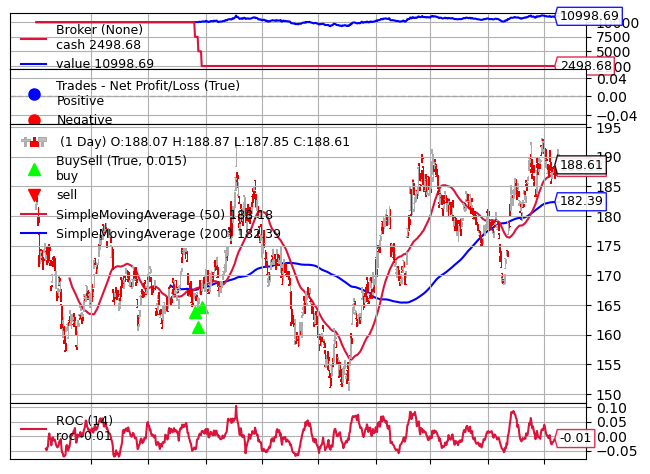

In [72]:
##############################################
# Main function to run the backtest
##############################################
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    cerebro.broker.setcash(10000.0)

    # Download historical data with grouping by ticker so we get a MultiIndex
    df = yf.download(ticker, start=start_date, end=end_date, group_by='ticker')
    if df.empty:
        raise Exception("No data downloaded. Check your ticker or date range.")

    # --- Handle DataFrame Column Names ---
    # If the DataFrame has a MultiIndex, extract the inner DataFrame for our ticker.
    if isinstance(df.columns, pd.MultiIndex):
        if ticker in df.columns.levels[0]:
            df = df[ticker]
        else:
            # Alternatively, if the second level has the desired names, use them:
            df.columns = df.columns.get_level_values(1)
    
    # Now force the columns to be lowercase.
    # Sometimes the DataFrame might not have the expected column names.
    # We expect these columns: open, high, low, close, volume.
    try:
        df.columns = df.columns.str.lower()
    except AttributeError:
        # If df.columns is not a Index with .str (e.g. already a plain list), skip this step.
        pass

    # Check if our DataFrame has the expected columns.
    expected_cols = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df.columns for col in expected_cols):
        # If not, assume the columns are in the correct order and manually assign them.
        df = df.iloc[:, :len(expected_cols)]
        df.columns = expected_cols

    # (Optional) If you have extra columns (like "adj close") you can drop them:
    df = df[expected_cols]

    # Create a Data Feed using our custom subclass.
    data = MyPandasData(dataname=df)
    cerebro.adddata(data)

    # -------------------------------
    # Choose the strategy to run:
    cerebro.addstrategy(TQQQ_SMACrossoverStrategy)
    # -------------------------------

    print(f"Starting Portfolio Value: ${cerebro.broker.getvalue():.2f}")
    cerebro.run()
    print(f"Final Portfolio Value: ${cerebro.broker.getvalue():.2f}")
    
    # Now plot with interactive plotting disabled
    figs = cerebro.plot(iplot=False, volume=False)
    
    # cerebro.plot returns a (possibly nested) list of figure objects.
    # Loop through and display each one:
    for fig_list in figs:
        # Sometimes the figures are nested in a list per strategy:
        if isinstance(fig_list, list):
            for fig in fig_list:
                plt.show(fig)
        else:
            plt.show(fig_list)